In [1]:
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.patches as mpatches
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# import pandas & numpy library
import pandas as pd
import numpy as np

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy import stats

import re
import csv

# **Clean Data**

Drop/rename and create columns

In [2]:
data = pd.read_csv('164_data.csv')

# Drop and rename columns
data = data.drop(labels = ['EndDate', 'SC0', 'SC3', 'Duration (in seconds)', 'Status', 'IPAddress', 'Progress', 
        'Finished', 'RecordedDate', 'ResponseId',
        'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
        'ExternalReference', 'LocationLatitude', 'LocationLongitude',
        'DistributionChannel', 'UserLanguage', 'Q9',
        'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q20',
        'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29',
        'Q32_1', 'Q32_2', 'Q32_3',
        'Q32_4', 'Q32_5', 'Q32_6', 'Q32_7', 'Q32_8', 'Q32_9', 'Q32_10',
        'Q32_11', 'Q32_12', 'Q32_13', 'Q32_14', 'Q32_15', 'Q32_16'], axis=1)

data.columns = ['StartDate', 'Q_Eat', 'Q_Sleep', 'Q_Comfort', 'Q_Exercise',
       'C_First Click', 'C_Last Click', 'C_Page Submit',
       'C_Click Count', 'E_First Click', 'E_Last Click',
       'E_Page Submit', 'E_Click Count',
       'Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec', 'PSS',
       'Worry', 'IM', 'IR', 'ER', 'AM', 'KeyResponses', 'PlayerScore']

data = data.iloc[1:]

# Add column describing experimental/control group
data = data.assign(Group= data['C_Page Submit'].isna().apply(lambda x: 'Experimental' if x == True else 'Control'))

In [3]:
# Combine column repeats
def combine_CE(data):
    CE_cols = np.unique([col[1] for col in data.columns.str.split('_') if col[0] in ['C', 'E']])
    for label in CE_cols:
        C_col = f"C_{label}"
        E_col = f"E_{label}"
        if C_col in data.columns and E_col in data.columns:
            data = data.assign(**{label: data[C_col].fillna(data[E_col])})
            data = data.drop(labels= [C_col, E_col], axis=1)

    return data

data = combine_CE(data)

Extract demographic information since it's not being included in any analysis

In [4]:
# Split data into data for analysis and demographic information
demographic_info = data[['Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec']]
data = data[data.columns.difference(['Q_Age', 'Q_Gender', 'Q_Ethn', 'Q_Income', 'Q_FinSec'])].drop(labels= ['First Click', 'Last Click'], axis=1)

Covert numeric columns to floats, add SDI column, and reorder columns/add multi-index

In [5]:
# Convert numeric columns to floats for handling
def float_convert(value):
    try:
        return float(value)
    except:
        return np.nan

num_cols = ['PSS', 'Worry', 'IM', 'IR', 'ER', 'AM', 'PlayerScore', 'Page Submit']
for col in num_cols:
    data[col] = data[col].apply(float_convert)

In [6]:
# Add column for self-determination scale based on the formula
data = data.assign(SDI= 2*data["IM"]+data["IR"]-data["ER"]-2*data["AM"])

In [7]:
# Reorder columns for salience and create multi-index
data = data[['StartDate', 'Group', 'Page Submit', 'PlayerScore', 'Worry', 'PSS', 'SDI', 'IM', 'IR', 'ER', 'AM',
       'Q_Comfort', 'Q_Eat', 'Q_Exercise', 'Q_Sleep', 'Click Count', 'KeyResponses']]

multi_index = [
    ('Metadata', 'StartDate'),
    ('Metadata', 'Group'),
    ('Task', 'Page Submit'),
    ('Task', 'PlayerScore'),
    ('Psych', 'Worry'),
    ('Psych', 'PSS'),
    ('SIMS', 'SDI'),
    ('SIMS', 'IM'),
    ('SIMS', 'IR'),
    ('SIMS', 'ER'),
    ('SIMS', 'AM'),
    ('Questions', 'Comfort'),
    ('Questions', 'Eat'),
    ('Questions', 'Exercise'),
    ('Questions', 'Sleep'),
    ('Interactions', 'Click Count'),
    ('Interactions', 'KeyResponses')
]

# Assign MultiIndex to DataFrame columns
data.columns = pd.MultiIndex.from_tuples(multi_index)

In [8]:
# Remove rows will null values
data = data[data[['Task', 'Psych', 'SIMS']].isna().any(axis=1) == False]

In [9]:
# Data after cleaning
data.head()

Metadata                      Task             Psych        SIMS        \
      StartDate         Group Page Submit PlayerScore Worry   PSS   SDI    IM   
1  3/7/25 15:06  Experimental     651.983       750.0  31.0  13.0   0.0  13.0   
2  3/7/25 15:52       Control      46.312         0.0  33.0  28.0  12.0  19.0   
3  3/7/25 17:40       Control     312.924       600.0  14.0  10.0  30.0  28.0   
4  3/8/25 00:01  Experimental     610.575      1050.0  37.0  18.0   3.0  19.0   
5  3/8/25 17:51  Experimental     612.827       650.0  50.0  32.0   0.0  13.0   

                                  Questions                                  \
     IR    ER    AM                 Comfort            Eat         Exercise   
1  10.0   4.0  16.0    Somewhat comfortable  ≤ 2 hours ago  1-2 days a week   
2  10.0  16.0  10.0  Somewhat uncomfortable  ≤ 2 hours ago  1-2 days a week   
3  10.0  16.0  10.0    Somewhat comfortable  3-5 hours ago  3-5 days a week   
4  16.0  13.0  19.0  Somewhat uncomfortable  ≤ 2 hours ago  6-7 days a week   
5   7.0  13.0  10.0      Very uncomfortable  ≤ 2 hours ago  3-5 days a week   

             Interactions               
       Sleep  Click Count KeyResponses  
1  5-7 hours            0          NaN  
2  5-7 hours            1          NaN  
3  5-7 hours            0            i  
4  5-7 hours            0          NaN  
5  2-4 hours            1          NaN

**Separate data into two data frames:** Control and Experimental
- *(makes some functions easier, but these dataframes will not always be used)*

In [10]:
# Create two dataframes: separate data from each group
E_data = data[data['Metadata','Group'] == 'Experimental']
C_data = data[data['Metadata','Group'] == 'Control']

# **Plotting**

### Distributions of numeric variables

*For measures that are taken before the task commences (PSS and Worry), these distributions should look relatively simiar between groups.
All other distributions might be affected by group*

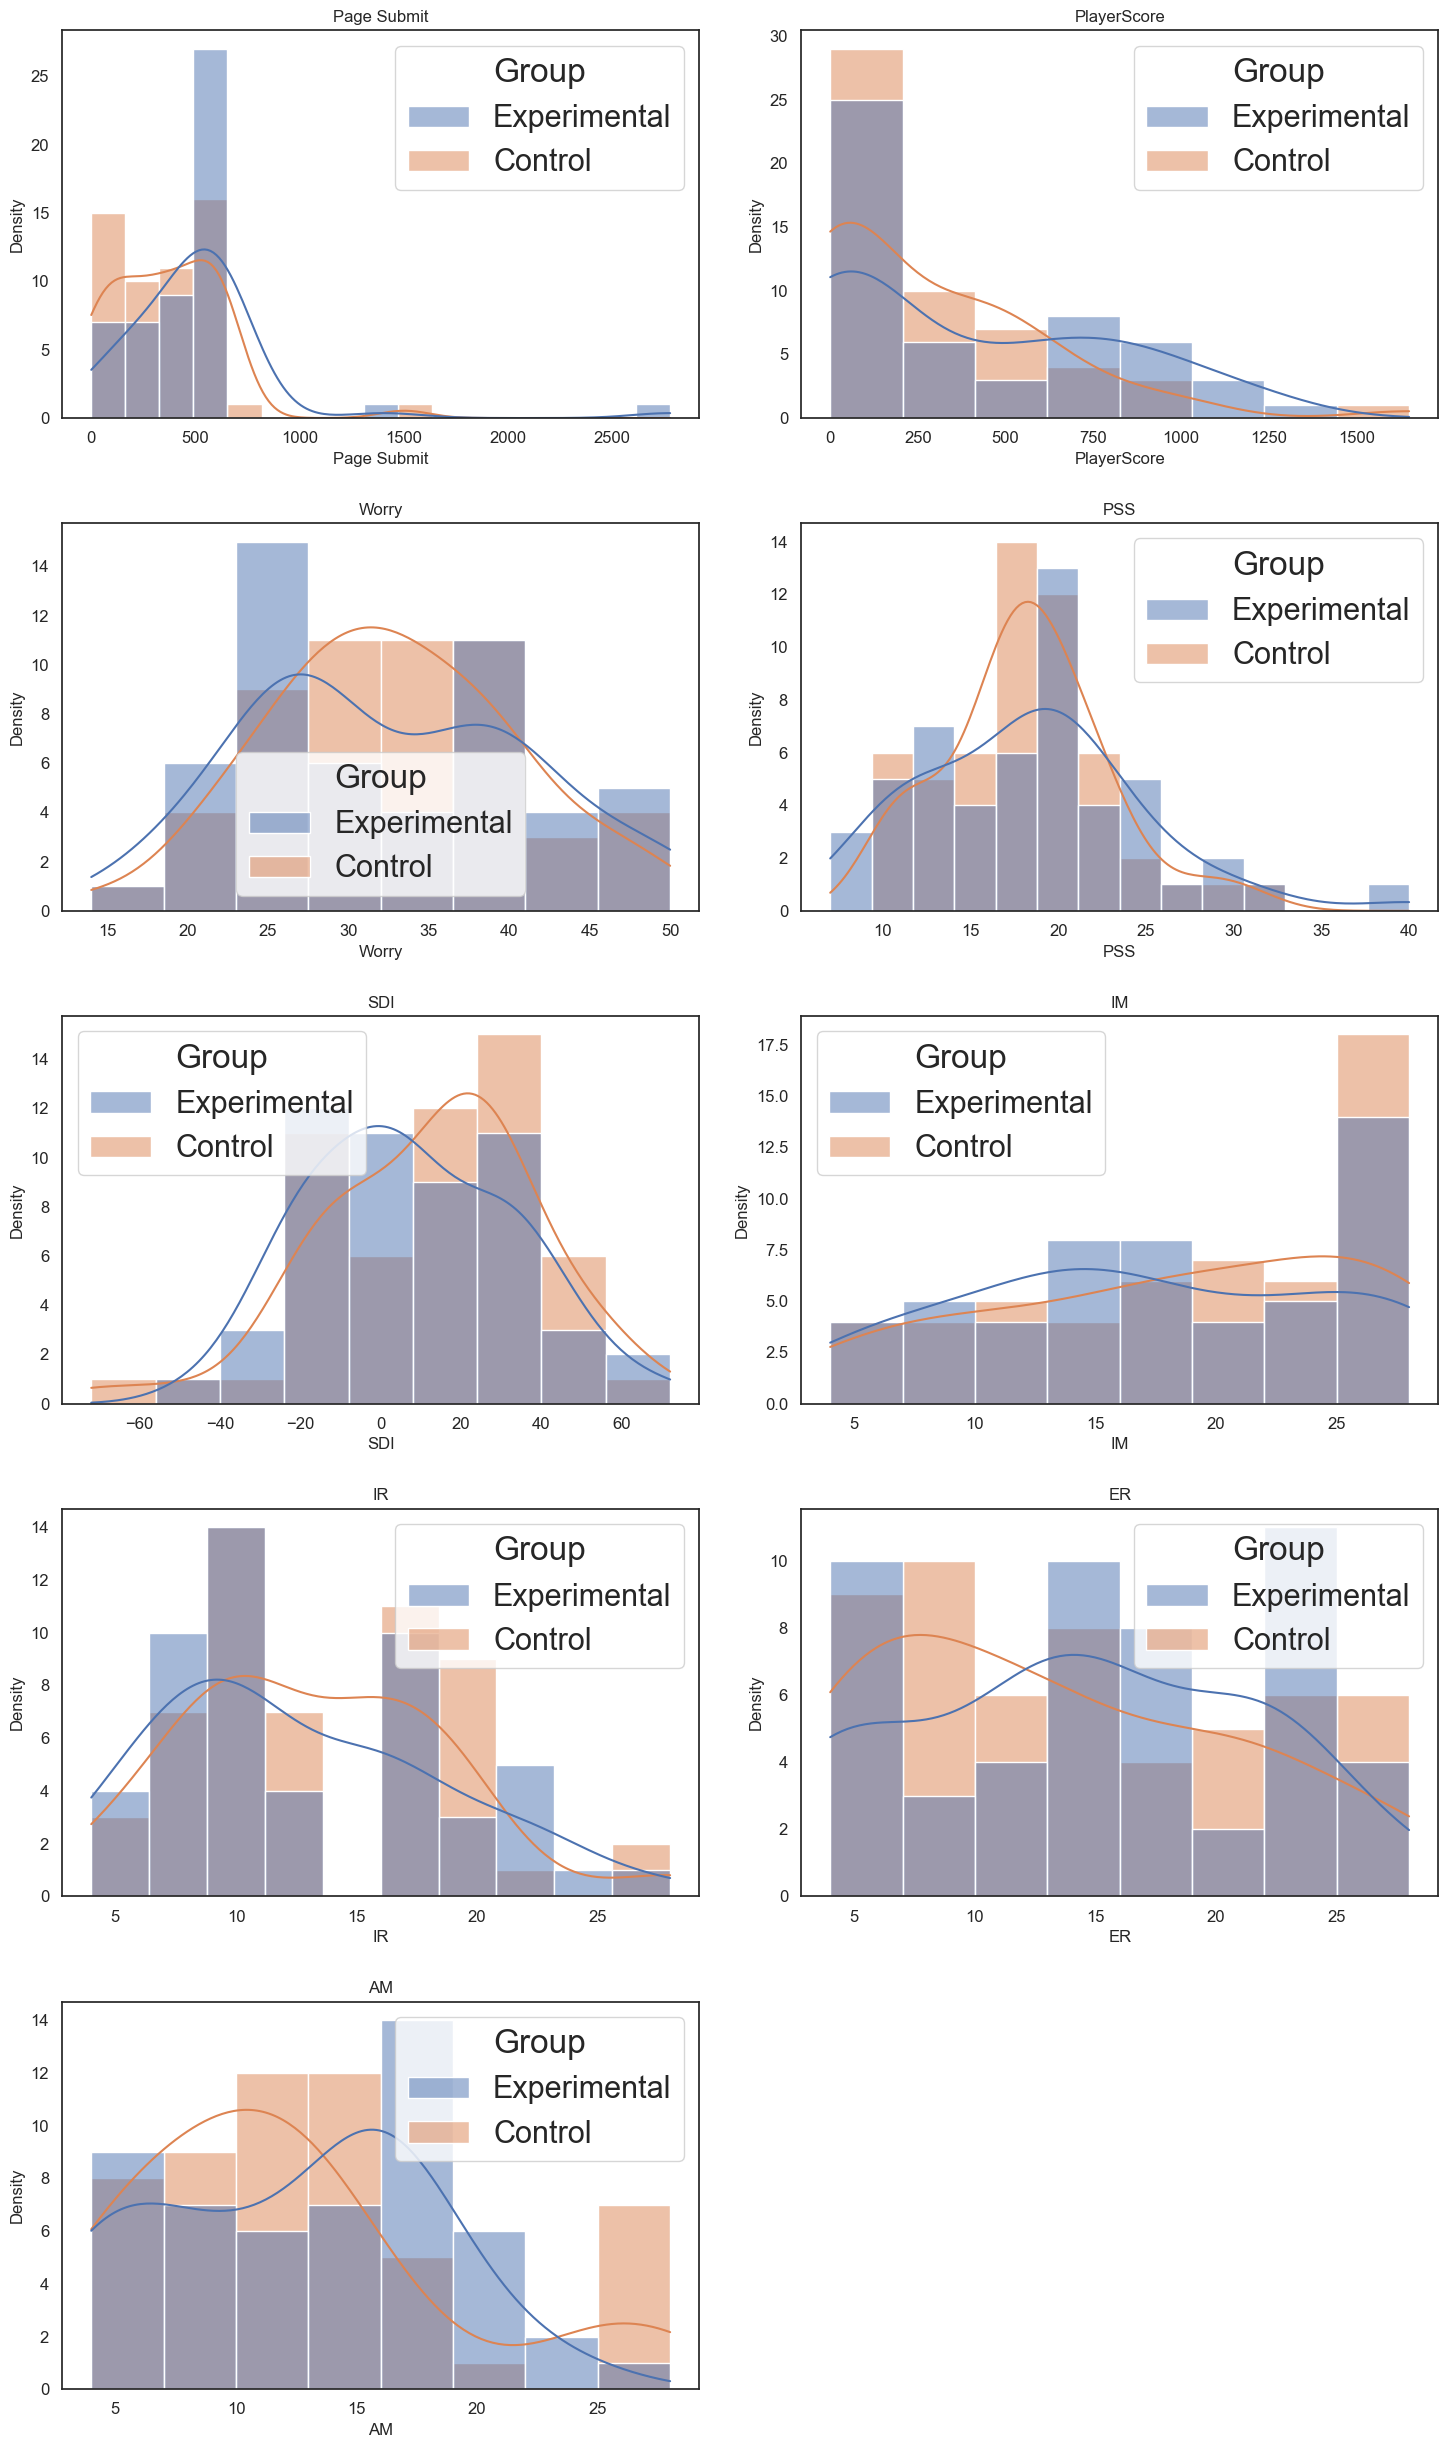

In [11]:
# Plot distributions of all numeric variables between groups
def btwn_groups_plots(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size =12
    i = 0

    if v * h == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Use second level of multi-index to index columns for plotting
    data2 = data.droplevel(level=0, axis=1)

    # Only plot numeric columns
    for col in data[['Task', 'Psych', 'SIMS']].columns.get_level_values(1):
        sns.histplot(data= data2, x= col, ax=axes[i], hue= 'Group', kde= True, common_norm= True)
        axes[i].set_title(col, fontsize=label_size)
        axes[i].set_xlabel(col, fontsize=label_size)
        axes[i].set_ylabel('Density', fontsize=label_size)
        axes[i].tick_params(axis="both", labelsize=label_size)
        i += 1

    fig.delaxes(axes[-1])
    plt.tight_layout()

btwn_groups_plots(data, [len(num_cols)//2+1, 2, 1], [15, 25])

## Scatterplots of numeric variables vs. PlayerScore and Page Submit (quitting time)

In [12]:
# Functions relationships of all numeric variable to task score and quitting time
def within_groups_plots(data, subplots, fig_size):
    v, h = subplots[:2]
    fig, axes = plt.subplots(v, h, figsize=fig_size)
    label_size = 9
    i = 0

    if v * h == 1:
        axes = [axes]  # Convert single-axis to a list
    else:
        axes = axes.flatten()

    data2 = data.droplevel(level=0, axis=1)
    for y_col in data['Task'].columns:
        for x_col in data[['Psych', 'SIMS']].columns.get_level_values(1):
            sns.scatterplot(data= data2, x= x_col, y= y_col, hue= "Group", ax=axes[i])
            axes[i].set_title(f"{y_col} vs. {x_col}", fontsize=label_size)
            axes[i].set_xlabel(x_col, fontsize=label_size)
            axes[i].set_ylabel(y_col, fontsize=label_size)
            axes[i].tick_params(axis="both", labelsize=label_size)
            axes[i].legend(fontsize= label_size)
            i += 1

    if len(subplots) == 3:
        extra_axes = v * h - i
        for j in range(extra_axes):
            plt.delaxes(axes[i + j])
            
    plt.tight_layout()

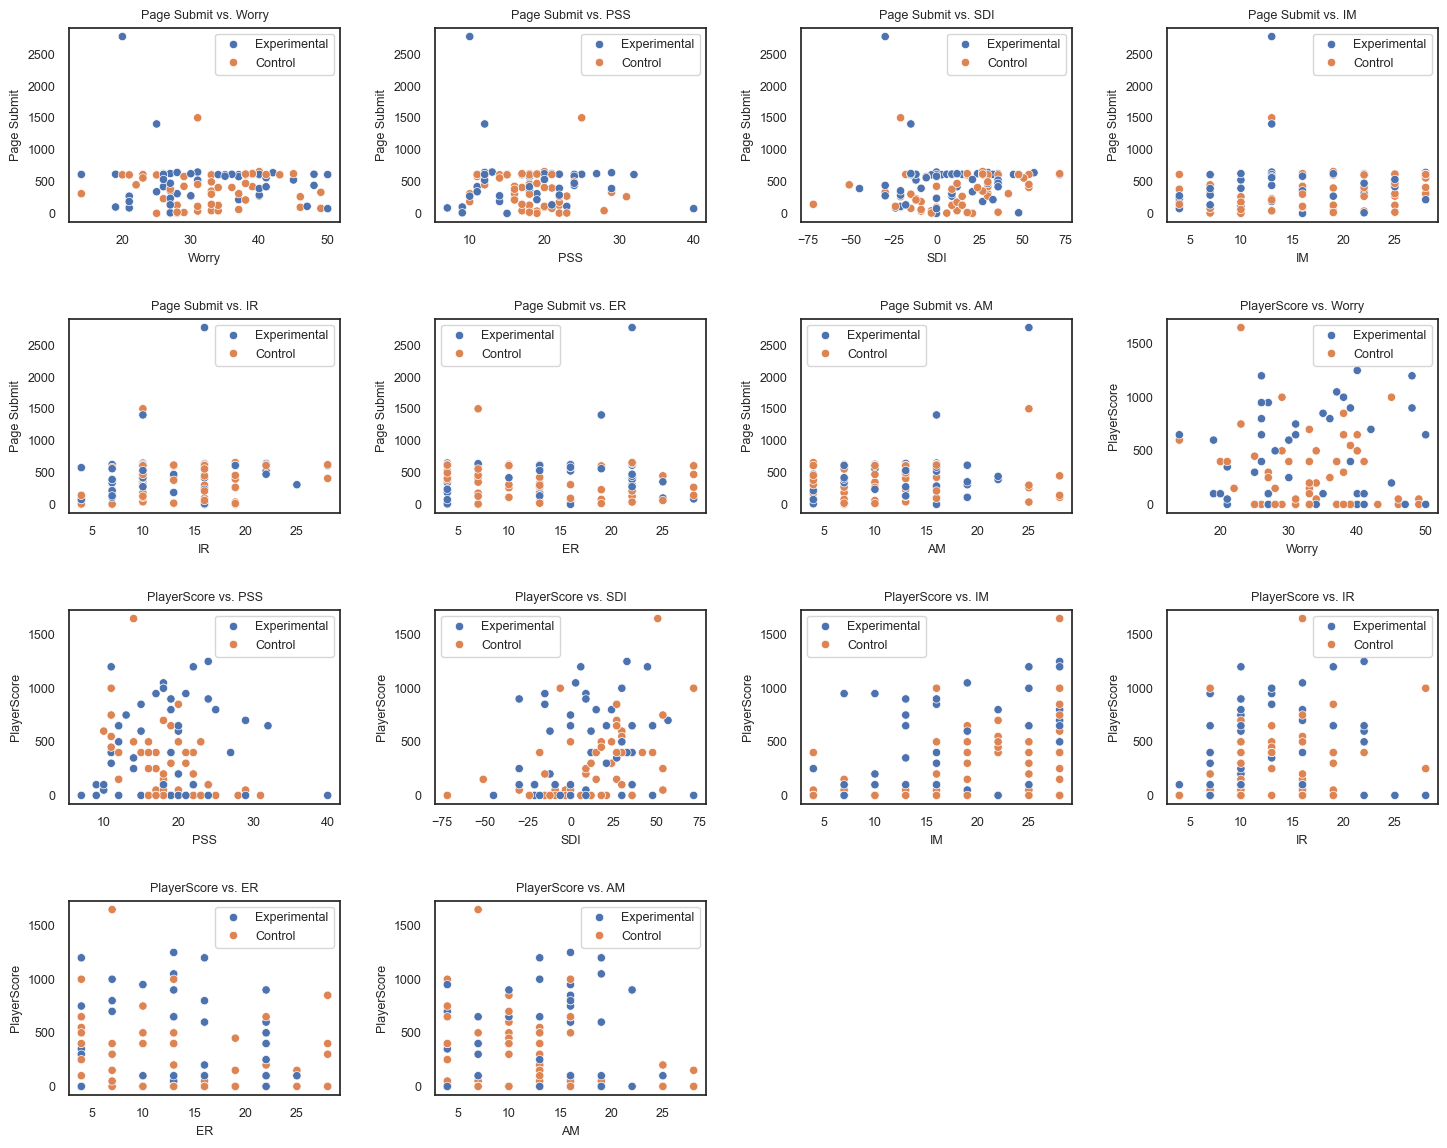

In [13]:
# Plot experimental group data
within_groups_plots(data, [4, 4, 1], [15, 12])

## Score/Quitting Time Distribution Boxplots

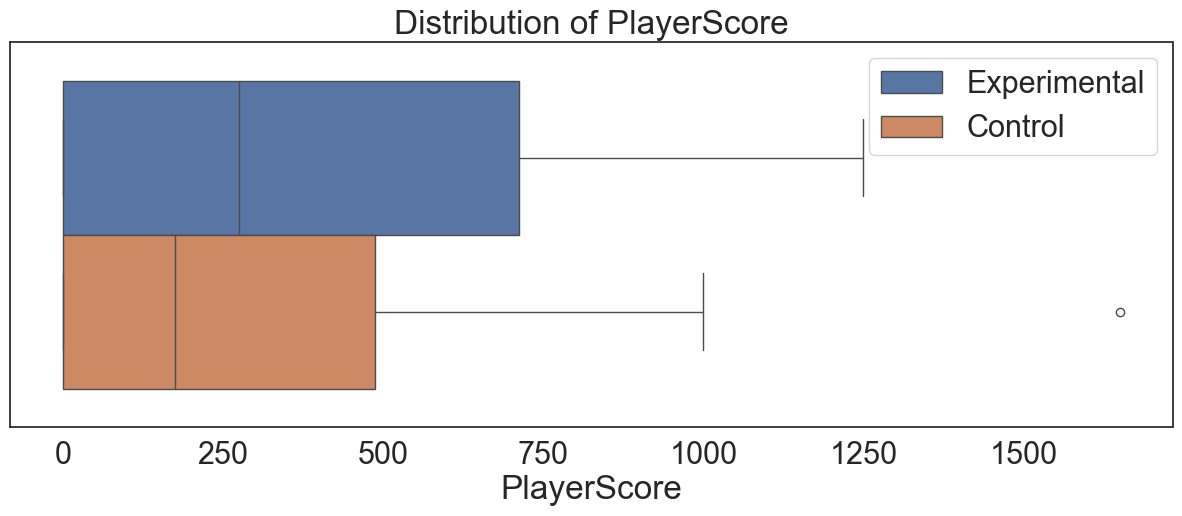

In [14]:
# Plot distributions of player score between groups
plt.figure(figsize= (15,5))
sns.boxplot(data=data.droplevel(level=0, axis=1), x="PlayerScore", hue="Group")
plt.title("Distribution of PlayerScore")
plt.legend(loc= "upper right")

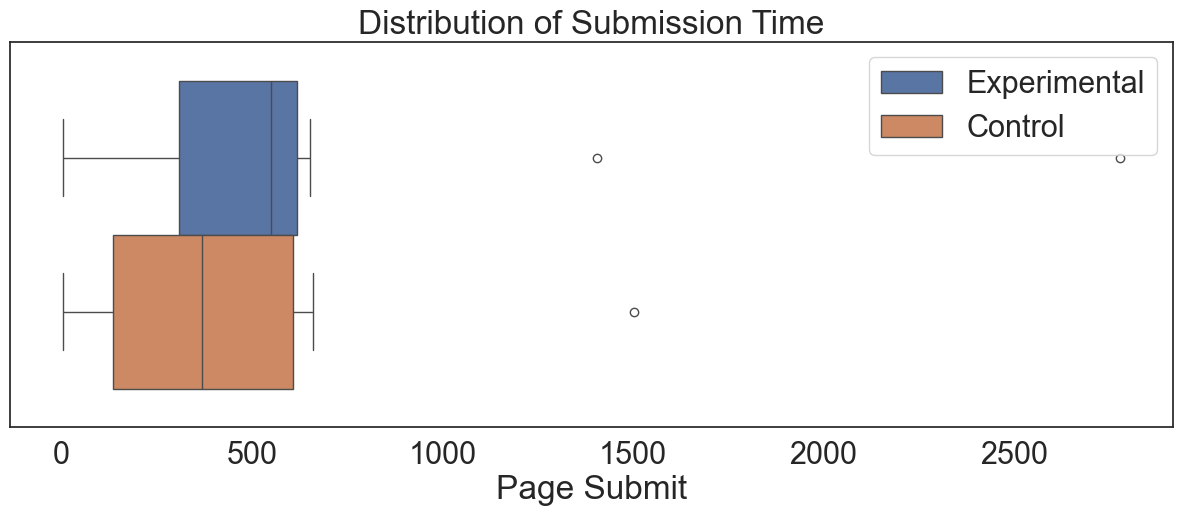

In [15]:
# Plot distributions of quitting time between groups
plt.figure(figsize= (15,5))
sns.boxplot(data=data.droplevel(level=0, axis=1), x="Page Submit", hue="Group")
plt.title("Distribution of Submission Time")
plt.legend(loc= "upper right")

# **Spearman's Coefficients and Correlations**

Spearman's Rank Correlation Coefficients: describe the correlation of numeric variables to score and quitting time

In [16]:
# Calculate spearman correlations between variables
spearman_E = E_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]
spearman_C = C_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]

/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_16121/4250275342.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman_E = E_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]
/var/folders/9z/nk4kcdcx20z9nh12_3vjt7jc0000gn/T/ipykernel_16121/4250275342.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  spearman_C = C_data.droplevel(level=0, axis=1).corr(method= 'spearman').iloc[2:, :2]


Experimental group correlations

In [17]:
# Spearman's correlations for the experiemental group
spearman_E

,Page Submit,PlayerScore
Worry,0.063061,0.056313
PSS,0.129697,0.045672
SDI,0.222209,0.248644
IM,0.373598,0.372331
IR,0.297899,0.232107
ER,-0.028833,-0.131585
AM,0.179006,0.200820


Control group correlations

In [18]:
# Spearman's correlations for the control group
spearman_C

,Page Submit,PlayerScore
Worry,0.155498,-0.005944
PSS,-0.275032,-0.358012
SDI,0.389738,0.513500
IM,0.413886,0.523018
IR,0.214045,0.214155
ER,-0.200278,-0.124097
AM,-0.035932,-0.170281


## Plot correlation coefficients to visualize which variables are most correlated to score/quitting time

Correlation plot for quitting time

Text(0.5, 0, 'Survey Score')

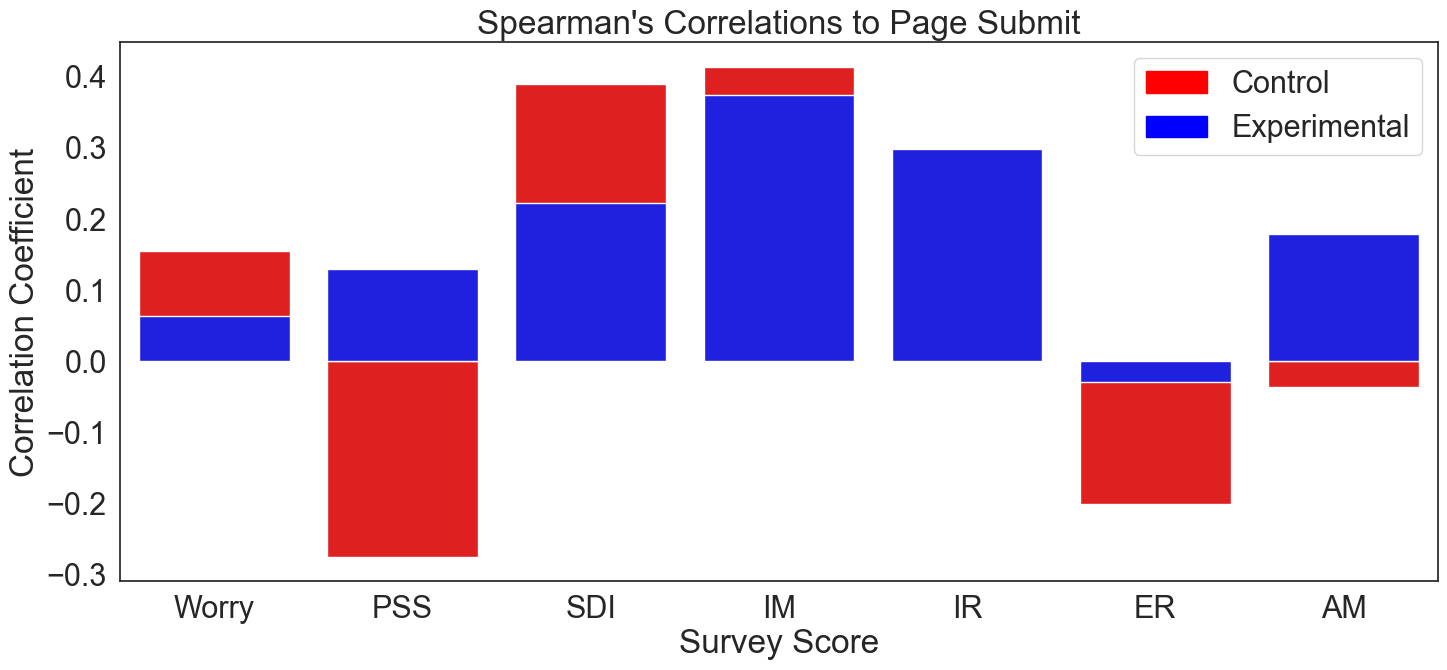

In [19]:
# Plot correlations to quitting time of all survey results
C_bar = sns.barplot(data= spearman_C["Page Submit"], color= 'red')
C_patch = mpatches.Patch(color='red', label='Control')
E_bar = sns.barplot(data= spearman_E["Page Submit"], color= 'blue')
E_patch = mpatches.Patch(color='blue', label='Experimental')
plt.legend(handles= [C_patch, E_patch])
plt.title("Spearman's Correlations to Page Submit")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Survey Score")

Correlation plot for score

Text(0.5, 0, 'Survey Score')

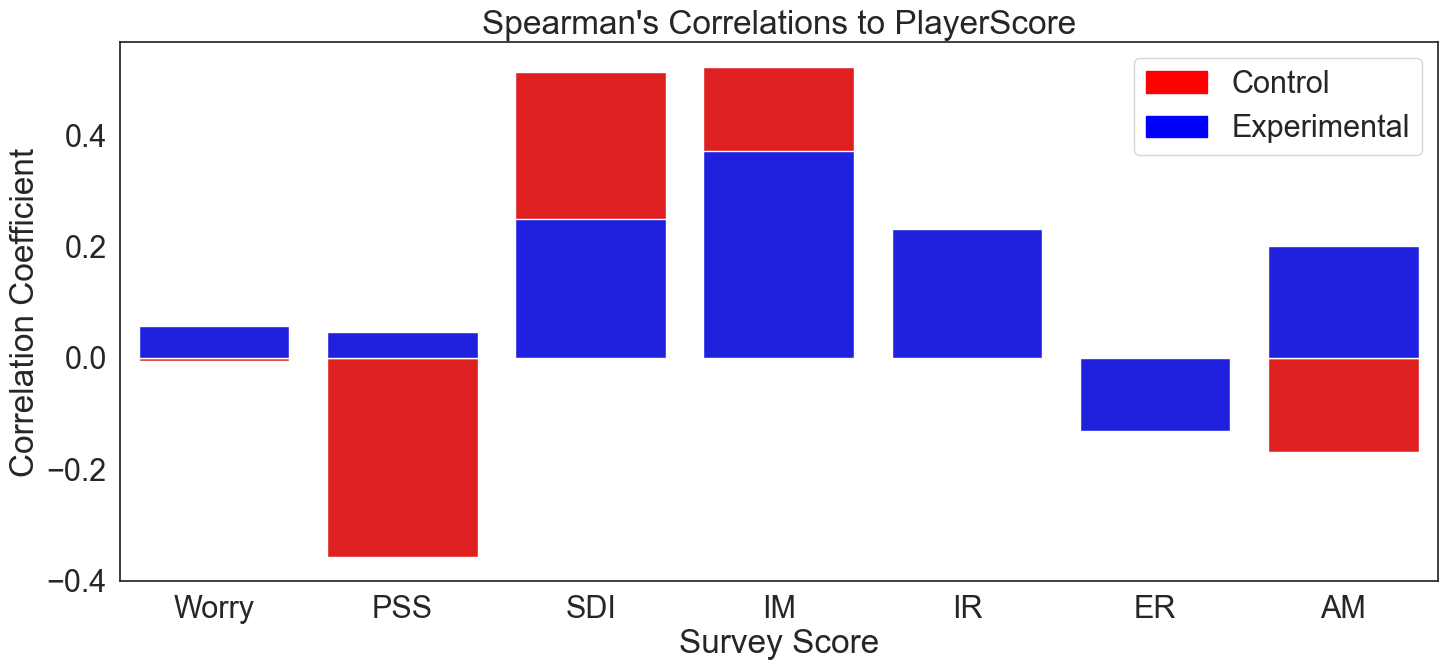

In [20]:
# Plot correlations to score of all survey results
C_bar = sns.barplot(data= spearman_C["PlayerScore"], color= 'red')
C_patch = mpatches.Patch(color='red', label='Control')
E_bar = sns.barplot(data= spearman_E["PlayerScore"], color= 'blue')
E_patch = mpatches.Patch(color='blue', label='Experimental')
plt.legend(handles= [C_patch, E_patch])
plt.title("Spearman's Correlations to PlayerScore")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Survey Score")

## P-values for correlations

In [21]:
# Create function to get p-values
def get_pval(data, degrees_of_freedom, tails= "two-sided"):
    tstat_df = data.apply(lambda r: r * np.sqrt(len(C_data) - 2) / np.sqrt(1 - r**2))
    if tails == "one-sided":
        pval_df = tstat_df.apply(lambda t: stats.t.cdf(t, degrees_of_freedom))
    elif tails == "two-sided":
        pval_df = tstat_df.apply(lambda t: 2 * (1 - stats.t.cdf(abs(t), degrees_of_freedom)))
    else:
        raise ValueError("tails must be defined")
    
    return pval_df

In [22]:
# Call get_pval function to create dataframes for the experiemental (E) and control (C) groups with significance of correlations
C_pvalues_df = get_pval(spearman_C, len(C_data)-1)
E_pvalues_df = get_pval(spearman_E, len(E_data)-1)

p-values for the control group

In [23]:
# Look at p-values for control
C_pvalues_df

,Page Submit,PlayerScore
Worry,0.261434,0.965970
PSS,0.044043,0.007816
SDI,0.003551,0.000070
IM,0.001846,0.000048
IR,0.120029,0.119834
ER,0.146373,0.371217
AM,0.796428,0.218204


p-values for the experimental group

In [24]:
# Look at p-values for experimental
E_pvalues_df

,Page Submit,PlayerScore
Worry,0.650579,0.685915
PSS,0.350014,0.742987
SDI,0.106440,0.069945
IM,0.005428,0.005600
IR,0.028768,0.091361
ER,0.836052,0.342984
AM,0.195387,0.145490


**Which p-values are significant for each group?**

In [59]:
# Function for printing which p-values are significant
def significant_pval(data, group):
    output = f"{group}: Significant P-values\n\n"
    threshold = 0.05
    sig_data = data.apply(lambda p: p <= threshold)
    for row in data.index:
        for col in data.columns:
            if sig_data.loc[row, col] == True:
                output += f"{row} vs. {col}:\t P-value: {data.loc[row, col]:10f}\n"
    return output

In [60]:
print(significant_pval(C_pvalues_df, "Control"))

Control: Significant P-values

PSS vs. Page Submit:	 P-value:   0.044043
PSS vs. PlayerScore:	 P-value:   0.007816
SDI vs. Page Submit:	 P-value:   0.003551
SDI vs. PlayerScore:	 P-value:   0.000070
IM vs. Page Submit:	 P-value:   0.001846
IM vs. PlayerScore:	 P-value:   0.000048



In [61]:
print(significant_pval(E_pvalues_df, "Experimental"))

Experimental: Significant P-values

IM vs. Page Submit:	 P-value:   0.005428
IM vs. PlayerScore:	 P-value:   0.005600
IR vs. Page Submit:	 P-value:   0.028768



# Mann-Whitney U Tests 
Testing significance of differences between groups

In [25]:
# Mann-Whitney U Tests for PlayerScore -- H1 : E > C
score_u_stat, score_pval = stats.mannwhitneyu(np.array(E_data['Task', 'PlayerScore']), 
                                     np.array(C_data['Task', 'PlayerScore']), 
                                     method='exact', alternative='greater')
print(f"The p-value for the distribution of score between groups given H1 : E > C is\t{score_pval}")

The p-value for the distribution of score between groups given H1 : E > C is	0.11239282492883129


In [26]:
# Mann-Whitney U Tests for Page Submit -- H1 : E > C
submit_u_stat, submit_pval = stats.mannwhitneyu(np.array(E_data['Task', 'Page Submit']), 
                                     np.array(C_data['Task', 'Page Submit']), 
                                     method='exact', alternative='greater')
print(f"The p-value for the distribution of quitting time between groups given H1 : E > C is\t{submit_pval}")

The p-value for the distribution of quitting time between groups given H1 : E > C is	0.002967127006452134


# **Demographic Information**

Text(0.5, 1.0, 'Participant Gender')

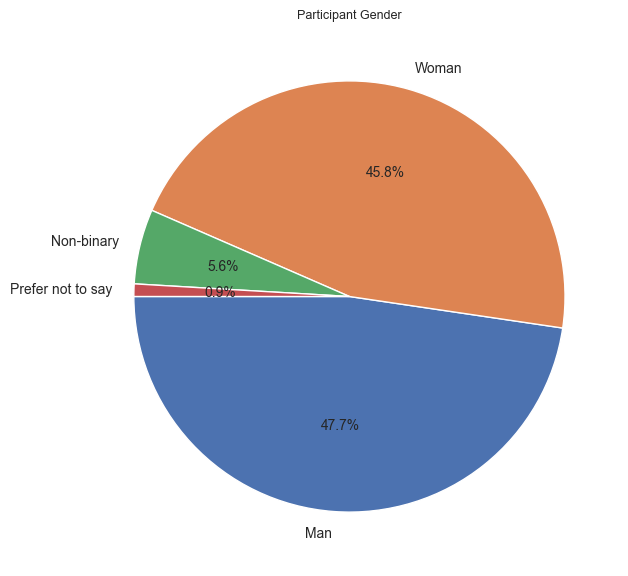

In [27]:
# Gender
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Gender"].value_counts(), labels= demographic_info["Q_Gender"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Gender", fontsize= labelsize)

Text(0.5, 1.0, 'Participant Age')

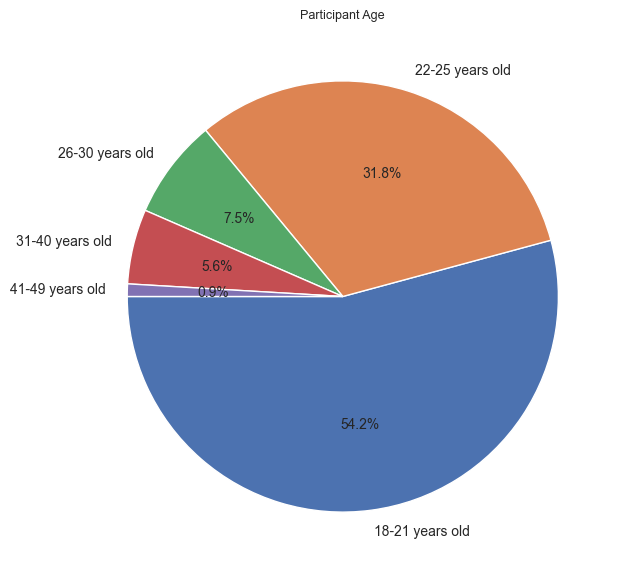

In [28]:
# Age
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Age"].value_counts(), labels= demographic_info["Q_Age"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Age", fontsize= labelsize)

Text(0.5, 1.0, 'Participant Ethnicity')

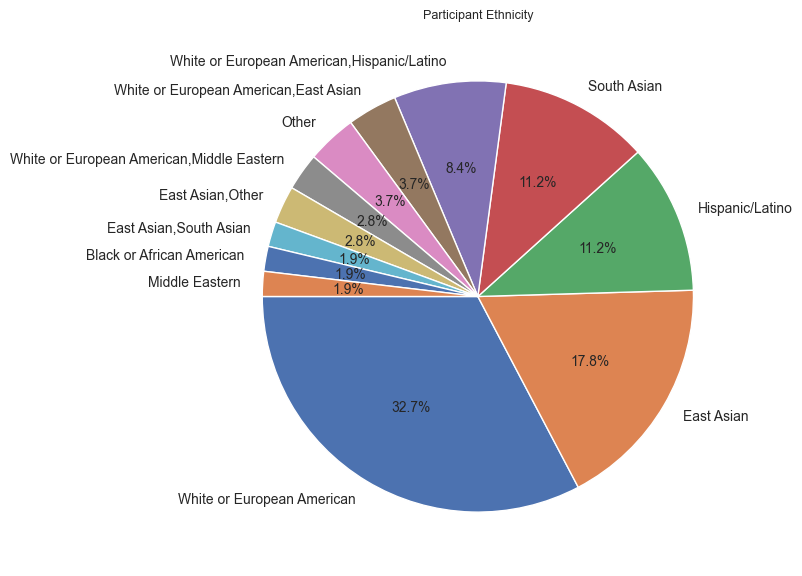

In [29]:
# Ethnicity
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Ethn"].value_counts(), labels= demographic_info["Q_Ethn"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Ethnicity", fontsize= labelsize)

Text(0.5, 1.0, 'Participant Income')

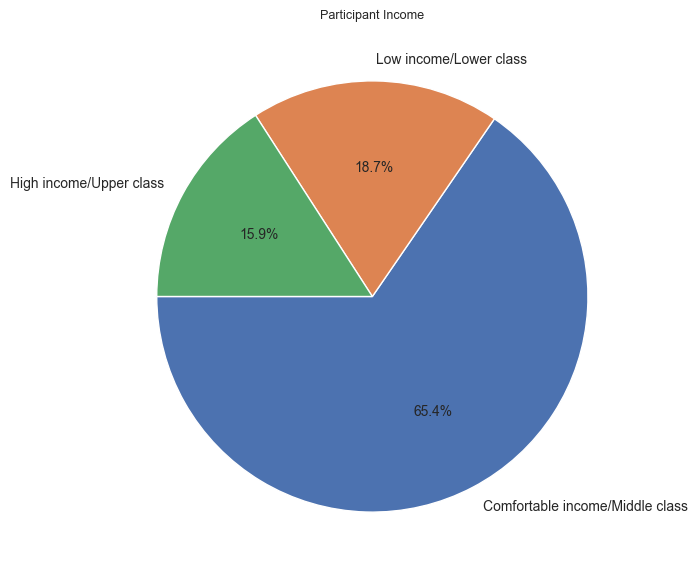

In [30]:
# Income
labelsize = 9
fig, ax = plt.subplots()
ax.pie(demographic_info["Q_Income"].value_counts(), labels= demographic_info["Q_Income"].value_counts().index, startangle=180, autopct='%1.1f%%', textprops= {"fontsize": 10})
ax.set_title("Participant Income", fontsize= labelsize)